# This script processes the o3memo results

1. Compile o3memo (both memo policies), o3memoA (only memoA) and o3memoB (only memoB) with:
```
make bin/o3memo [o3memoA, o3memoB]
```
2. Run the benchmarking script
```
cd scripts
python3 run_par_optim3
```
3. The output that we will process is o3_memoization_coffee.csv (renamed from o3_memoization.csv)


In [44]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import sys
from statistics import mean

def tokenize(filename):
    results ={}
    with open(filename) as f:
        next(f) # skip header
        for line in f:
            tokens = line.split()
            name=tokens[1].split("/")[3][:-5]
            nth=int(tokens[2])
            level=int(tokens[5])
            if name not in results:
                results[name]={}
            if level not in results[name]:
                results[name][level]={}
            results[name][level][nth]=[float(tokens[6])] # tree construction time
            results[name][level][nth].append(float(tokens[7])) # owm time
            results[name][level][nth].append(float(tokens[6])+float(tokens[7])) # total time
            results[name][level][nth].append(float(tokens[8])) # accuracy
    return results

def tokenize2(filename):
    results ={}
    with open(filename) as f:
        next(f) # skip header
        for line in f:
            tokens = line.split()
            name=tokens[0].split("/")[3][:-5]
            nth=int(tokens[1])
            level=int(tokens[4])
            if name not in results:
                results[name]={}
            if level not in results[name]:
                results[name][level]={}
            results[name][level][nth]=[float(tokens[5])] # tree construction time
            results[name][level][nth].append(float(tokens[6])) # owm time
            results[name][level][nth].append(float(tokens[5])+float(tokens[6])) # total time
            results[name][level][nth].append(float(tokens[7])) # accuracy
    return results

reso2=tokenize2("o2_partree_coffee.csv")
reso3A=tokenize("o3_memoizationA_coffee.csv") # optim3 without with just memo B
reso3B=tokenize("o3_memoizationB_coffee.csv") # optim3 without with just memo B
reso3=tokenize("o3_memoization_coffee.csv") # optim3 without with memo A and B


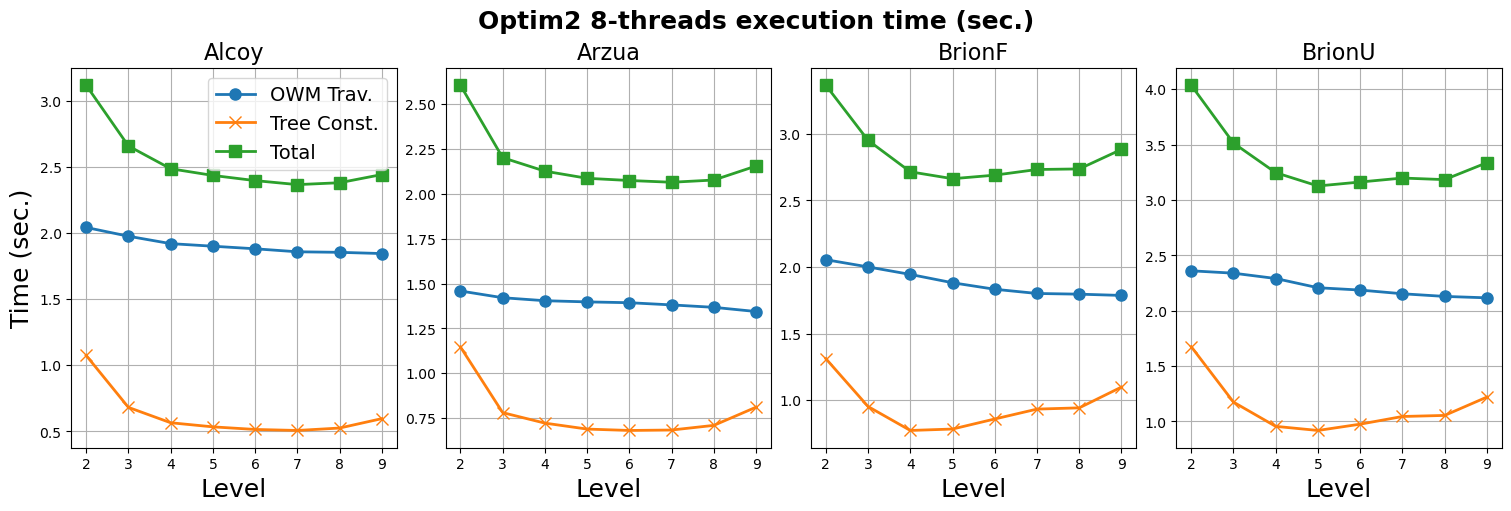

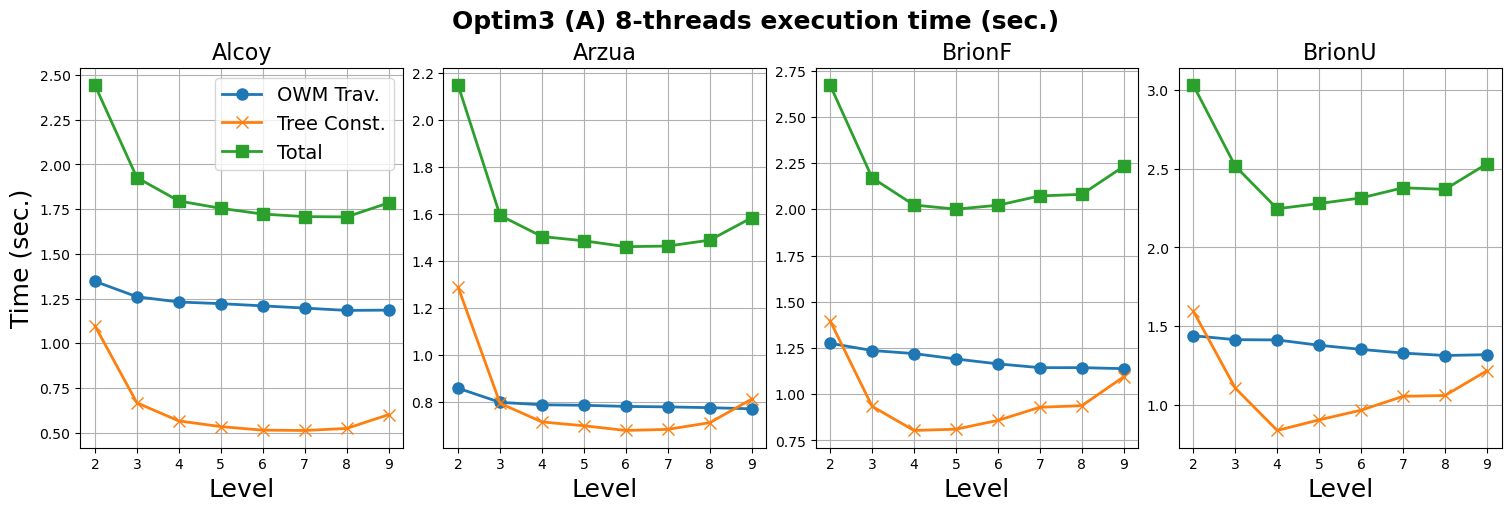

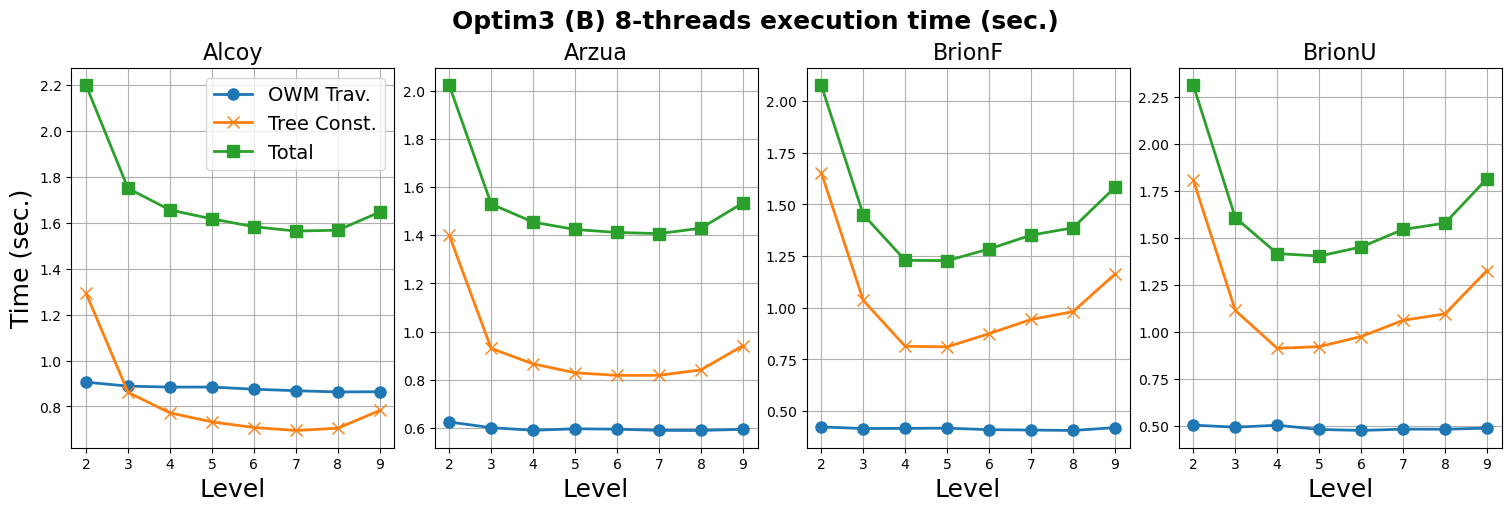

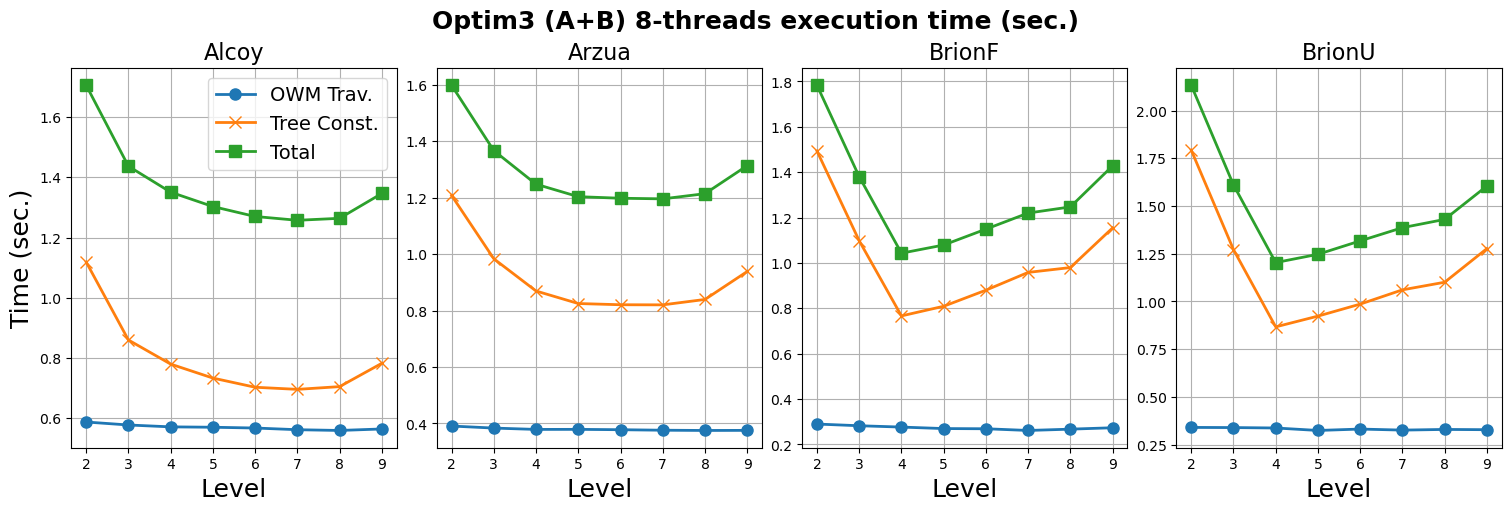

In [45]:
def plot_levels(nth,results, message):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    #fig = plt.figure()
    labels=['OWM Trav.','Tree Const.','Total']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4),['Alcoy','Arzua','BrionF','BrionU']):
        x=list(results[name].keys())
        axs[i].plot(np.array(x), np.array([results[name][j][nth][1] for j in x]), marks[0], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][j][nth][0] for j in x]), marks[1], linewidth=linew, markersize=markers)
        axs[i].plot(np.array(x), np.array([results[name][j][nth][2] for j in x]), marks[2], linewidth=linew, markersize=markers)

        axs[i].set_title(name,fontsize=16)
        axs[i].set_xlabel('Level', fontsize=xlabelfs)
        axs[i].set_xticks(x,fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()
    if(nth==1):
        fig.suptitle('Execution time (sec.)',  fontweight='bold', fontsize=18)
    if(nth==8):
        fig.suptitle(message+' 8-threads execution time (sec.)',  fontweight='bold', fontsize=18)

    axs[0].set_ylabel('Time (sec.)', fontsize=ylabelfs)
    axs[0].legend(labels,loc='best', fontsize= 14)
    # pp = PdfPages("Optim3_8coresExecTime.pdf")
    # pp.savefig(fig)
    # pp.close()

plot_levels(8,reso2, "Optim2")
plot_levels(8,reso3A, "Optim3 (A)")
plot_levels(8,reso3B, "Optim3 (B)")
plot_levels(8,reso3, "Optim3 (A+B)")


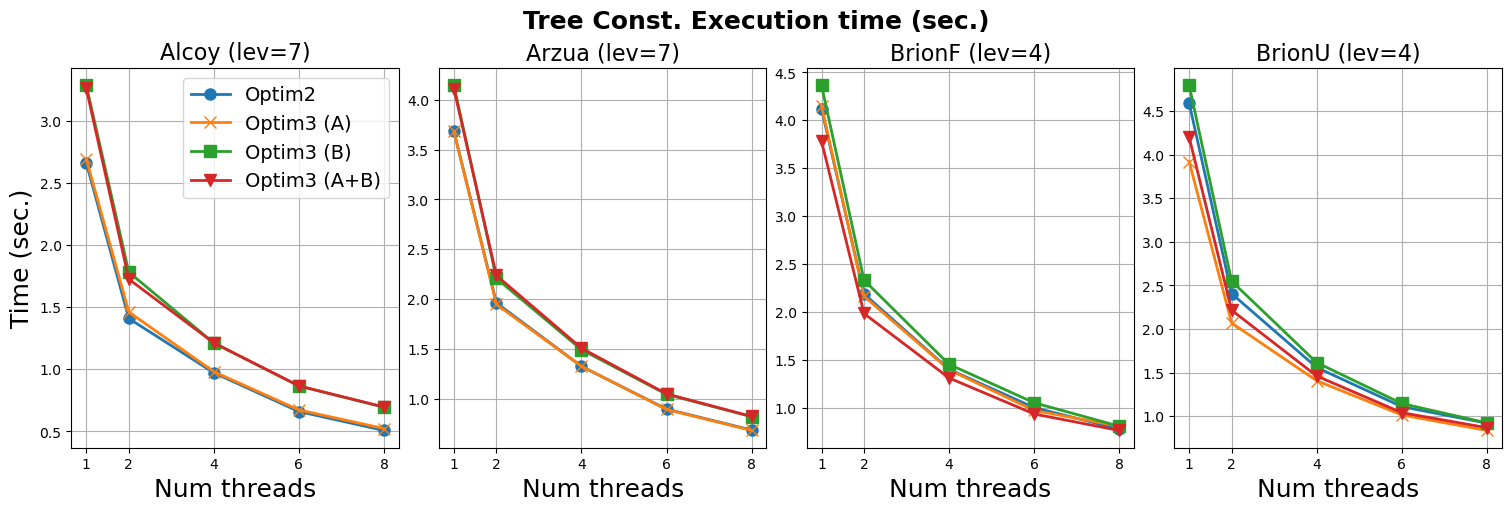

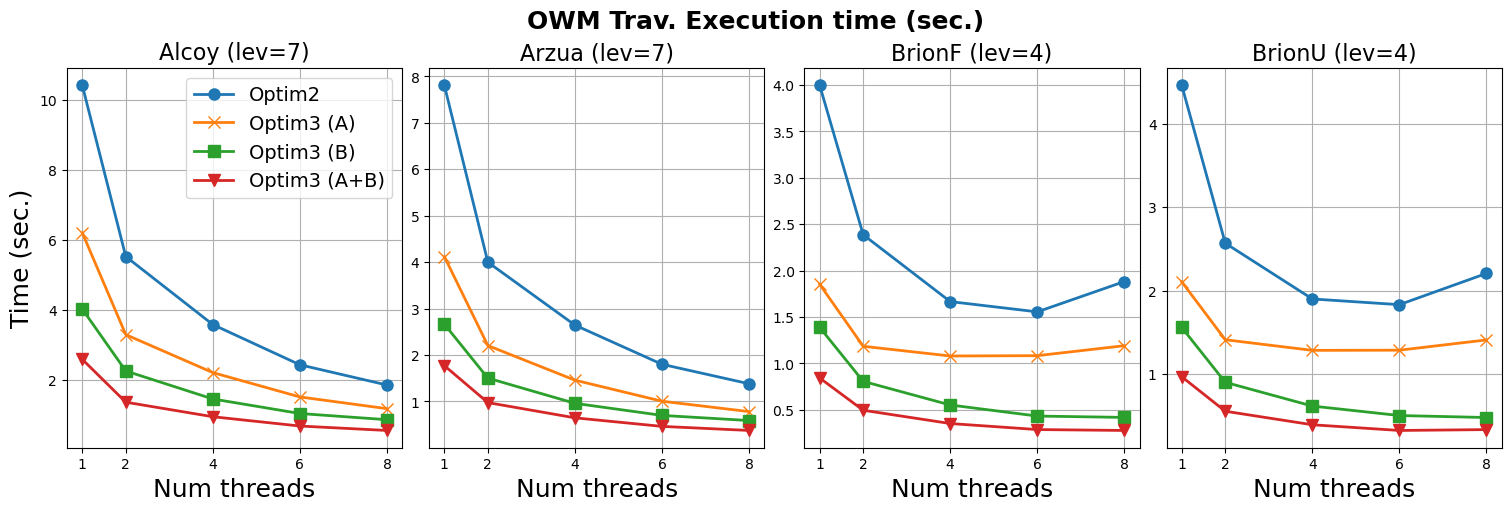

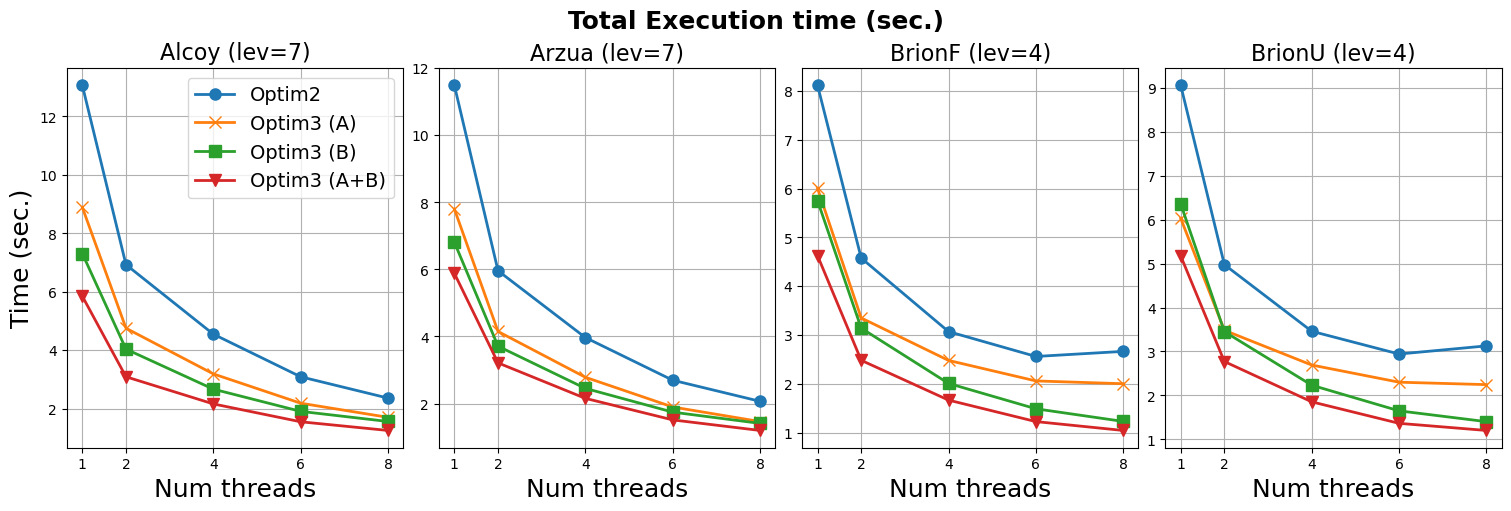

In [46]:
def plot_times(phase,results,message):
    #Configuration variables
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8
    marks=['o-','x-','s-','v-','+-']

    #fig = plt.figure()
    labels=['Tree Const.','OWM Trav.','Total']
    #define grid of plots
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 5), constrained_layout=True) #sharey=True
    for i,name in zip(range(4),['Alcoy','Arzua','BrionF','BrionU']):
        for j in range(4):
            bestlevel= min(results[j][name], key=lambda x: results[j][name][x][8][2])
            x=list(results[j][name][bestlevel].keys())
            axs[i].plot(np.array(x), np.array([results[j][name][bestlevel][nth][phase] for nth in x]), marks[j], linewidth=linew, markersize=markers)
        
        axs[i].set_title(name+ " (lev="+str(bestlevel)+")",fontsize=16)
        axs[i].set_xlabel('Num threads', fontsize=xlabelfs)
        axs[i].set_xticks(x,fontsize=xticksfs)
        # axs[i].yticks(fontsize=yticksfs)
        axs[i].grid()

    fig.suptitle(labels[phase]+' Execution time (sec.)',  fontweight='bold', fontsize=18)
    axs[0].set_ylabel('Time (sec.)', fontsize=ylabelfs)
    axs[0].legend(message,loc='best', fontsize= 14)
    #axs[i].show()

plot_times(0,[reso2,reso3A,reso3B,reso3],["Optim2","Optim3 (A)","Optim3 (B)","Optim3 (A+B)"])
plot_times(1,[reso2,reso3A,reso3B,reso3],["Optim2","Optim3 (A)","Optim3 (B)","Optim3 (A+B)"])
plot_times(2,[reso2,reso3A,reso3B,reso3],["Optim2","Optim3 (A)","Optim3 (B)","Optim3 (A+B)"])

# Compare OWM traversal improvement

In [74]:
def printall(phase,nth,res,message):
    labels=['Tree Const.','OWM Trav.','Total']
    bestlevel=[min(res[3][j], key=lambda x: res[3][j][x][nth][2]) for j in res[0]]
    print(bestlevel)
    for j,n in zip(res[0],range(len(res[0]))):   
        print("Cloud {} has best level for total time = {}.".format(j, bestlevel[n]))
    for j,n in zip(res[0],range(len(res[0]))):
        time=[] 
        for i in range(4):
            time.append(res[i][j][bestlevel[n]][nth][phase])  
            print("Cloud {} has {}-cores {} {} time = {:.4f} (speedup vs Optim2 = {:.2f}x).".format(j,nth,labels[phase], message[i], time[i], time[0]/time[i]))

   
#print("Cloud {} has {}-cores OWM optim3 time = {:.2f}. Speedup (o3 vs o2) = {:.2f}x.".format(i,nth,res2[i][bestlevel][nth][1], res1[i][bestlevel][nth][1]/res2[i][bestlevel][nth][1] ))    

printall(1, 8,[reso2,reso3A,reso3B,reso3],["Optim2","Optim3 (A)","Optim3 (B)","Optim3 (A+B)"])

[7, 7, 4, 4]
Cloud Alcoy has best level for total time = 7.
Cloud Arzua has best level for total time = 7.
Cloud BrionF has best level for total time = 4.
Cloud BrionU has best level for total time = 4.
Cloud Alcoy has 8-cores OWM Trav. Optim2 time = 1.8575 (speedup vs Optim2 = 1.00x).
Cloud Alcoy has 8-cores OWM Trav. Optim3 (A) time = 1.1964 (speedup vs Optim2 = 1.55x).
Cloud Alcoy has 8-cores OWM Trav. Optim3 (B) time = 0.8687 (speedup vs Optim2 = 2.14x).
Cloud Alcoy has 8-cores OWM Trav. Optim3 (A+B) time = 0.5616 (speedup vs Optim2 = 3.31x).
Cloud Arzua has 8-cores OWM Trav. Optim2 time = 1.3814 (speedup vs Optim2 = 1.00x).
Cloud Arzua has 8-cores OWM Trav. Optim3 (A) time = 0.7797 (speedup vs Optim2 = 1.77x).
Cloud Arzua has 8-cores OWM Trav. Optim3 (B) time = 0.5892 (speedup vs Optim2 = 2.34x).
Cloud Arzua has 8-cores OWM Trav. Optim3 (A+B) time = 0.3758 (speedup vs Optim2 = 3.68x).
Cloud BrionF has 8-cores OWM Trav. Optim2 time = 1.9442 (speedup vs Optim2 = 1.00x).
Cloud BrionF

# Compare Tree construction improvement

In [75]:
printall(0, 8,[reso2,reso3A,reso3B,reso3],["Optim2","Optim3 (A)","Optim3 (B)","Optim3 (A+B)"])

[7, 7, 4, 4]
Cloud Alcoy has best level for total time = 7.
Cloud Arzua has best level for total time = 7.
Cloud BrionF has best level for total time = 4.
Cloud BrionU has best level for total time = 4.
Cloud Alcoy has 8-cores Tree Const. Optim2 time = 0.5075 (speedup vs Optim2 = 1.00x).
Cloud Alcoy has 8-cores Tree Const. Optim3 (A) time = 0.5118 (speedup vs Optim2 = 0.99x).
Cloud Alcoy has 8-cores Tree Const. Optim3 (B) time = 0.6954 (speedup vs Optim2 = 0.73x).
Cloud Alcoy has 8-cores Tree Const. Optim3 (A+B) time = 0.6956 (speedup vs Optim2 = 0.73x).
Cloud Arzua has 8-cores Tree Const. Optim2 time = 0.6838 (speedup vs Optim2 = 1.00x).
Cloud Arzua has 8-cores Tree Const. Optim3 (A) time = 0.6841 (speedup vs Optim2 = 1.00x).
Cloud Arzua has 8-cores Tree Const. Optim3 (B) time = 0.8179 (speedup vs Optim2 = 0.84x).
Cloud Arzua has 8-cores Tree Const. Optim3 (A+B) time = 0.8201 (speedup vs Optim2 = 0.83x).
Cloud BrionF has 8-cores Tree Const. Optim2 time = 0.7713 (speedup vs Optim2 = 1.

# Compare Total (OWM traversal + Tree construction) improvement

In [76]:
printall(2, 8,[reso2,reso3A,reso3B,reso3],["Optim2","Optim3 (A)","Optim3 (B)","Optim3 (A+B)"]) 

[7, 7, 4, 4]
Cloud Alcoy has best level for total time = 7.
Cloud Arzua has best level for total time = 7.
Cloud BrionF has best level for total time = 4.
Cloud BrionU has best level for total time = 4.
Cloud Alcoy has 8-cores Total Optim2 time = 2.3650 (speedup vs Optim2 = 1.00x).
Cloud Alcoy has 8-cores Total Optim3 (A) time = 1.7082 (speedup vs Optim2 = 1.38x).
Cloud Alcoy has 8-cores Total Optim3 (B) time = 1.5641 (speedup vs Optim2 = 1.51x).
Cloud Alcoy has 8-cores Total Optim3 (A+B) time = 1.2573 (speedup vs Optim2 = 1.88x).
Cloud Arzua has 8-cores Total Optim2 time = 2.0652 (speedup vs Optim2 = 1.00x).
Cloud Arzua has 8-cores Total Optim3 (A) time = 1.4639 (speedup vs Optim2 = 1.41x).
Cloud Arzua has 8-cores Total Optim3 (B) time = 1.4071 (speedup vs Optim2 = 1.47x).
Cloud Arzua has 8-cores Total Optim3 (A+B) time = 1.1959 (speedup vs Optim2 = 1.73x).
Cloud BrionF has 8-cores Total Optim2 time = 2.7155 (speedup vs Optim2 = 1.00x).
Cloud BrionF has 8-cores Total Optim3 (A) time =

Phase: qtree speedup for each cloud and best level for each cloud: ['Alcoy', 'Arzua', 'BrionF', 'BrionU']
[1.         1.88949706 2.68949595 3.76348607 4.68800682]
[1.         1.83900879 2.73051686 3.9257435  5.01363467]
[1.         1.9051924  2.87984622 4.03164477 4.93662425]
[1.         1.8974417  2.8779237  4.04400465 4.84910914]
Phase: owm speedup for each cloud and best level for each cloud: ['Alcoy', 'Arzua', 'BrionF', 'BrionU']
[1.         1.89331205 2.71776492 3.76553378 4.61230536]
[1.         1.81514794 2.73522868 3.82122642 4.71449406]
[1.         1.70361403 2.3984662  2.94187033 3.04613153]
[1.         1.74277899 2.4581577  2.97179799 2.88083052]
Phase: total speedup for each cloud and best level for each cloud: ['Alcoy', 'Arzua', 'BrionF', 'BrionU']
[1.         1.891184   2.70193731 3.76439228 4.65419061]
[1.         1.83175836 2.73193391 3.89367594 4.9196417 ]
[1.         1.86501276 2.77831774 3.77690285 4.43542221]
[1.         1.86637137 2.78859572 3.78765427 4.29822257]


<Figure size 640x480 with 0 Axes>

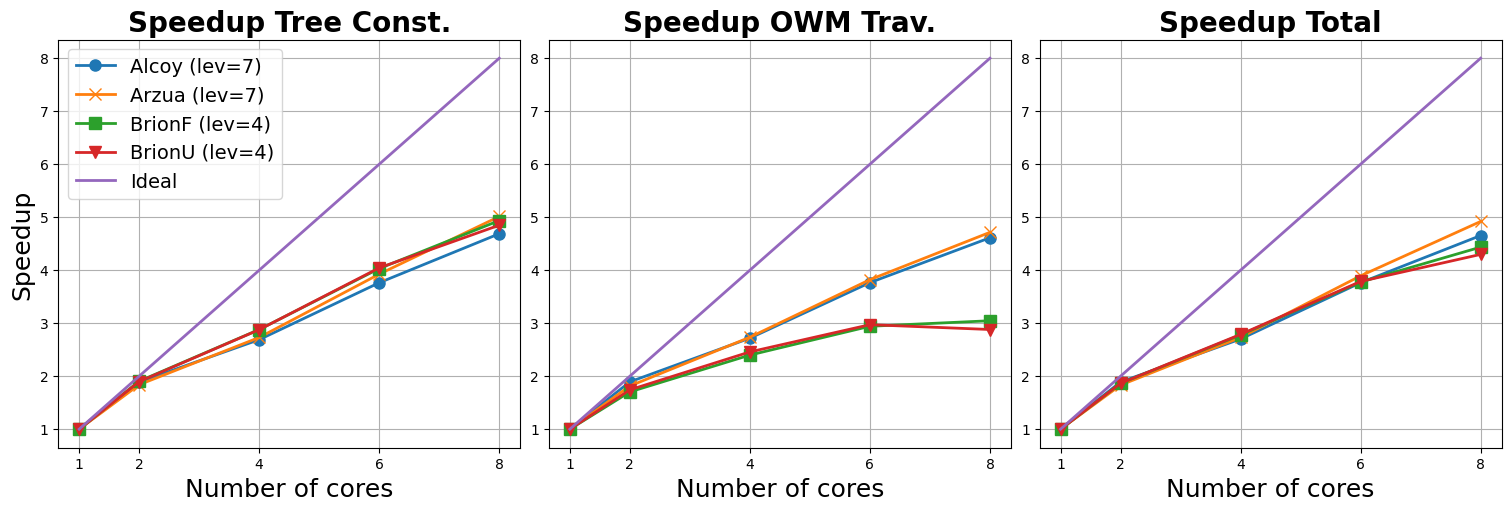

In [18]:
#Configuration variables
def plot_res(res):
    titlefs = 20
    ylabelfs = 18
    xlabelfs = 18
    xticksfs = 16
    yticksfs = 16
    legendfs = 14
    linew = 2
    markers = 8

    fig = plt.figure()

    marks=['o-','x-','s-','v-','+-']
    bestlevel=[min(res[i], key=lambda x: res[i][x][8][2]) for i in res]
    numthreads=list(res['Alcoy'][bestlevel[0]].keys())
    labels=['Tree Const.','OWM Trav.','Total']

    fig, axs = plt.subplots(nrows=1, ncols=3,figsize=(15, 5), constrained_layout=True)
    sizes=[i+" (lev="+str(j)+")" for i,j in zip(res,bestlevel)]
    sizes.append('Ideal')

    for phase,subfig in zip(['qtree','owm','total'],range(3)):
        print("Phase: "+phase+ " speedup for each cloud and best level for each cloud: "+str(list(res.keys())))
        for (i,z,lev) in zip(res,marks,bestlevel):
            print(np.array([res[i][lev][1][subfig]/res[i][lev][j][subfig] for j in numthreads]))
            axs[subfig].plot(np.array(numthreads), np.array([res[i][lev][1][subfig]/res[i][lev][j][subfig] for j in numthreads]), z, linewidth=linew, markersize=markers)
        axs[subfig].plot(np.array(numthreads), np.array(numthreads), '-', linewidth=linew, markersize=markers)
        axs[subfig].set_title('Speedup '+labels[subfig],  fontweight='bold', fontsize=titlefs)
        axs[subfig].set_xlabel('Number of cores', fontsize=xlabelfs)
        axs[subfig].set_xticks(numthreads,fontsize=xticksfs)
        axs[subfig].grid()

    axs[0].set_ylabel('Speedup', fontsize=ylabelfs)
    axs[0].legend(sizes,loc='best', fontsize= legendfs)
#    plt.yticks(fontsize=yticksfs)

    plt.show()

plot_res(reso3)

In [49]:
pp = PdfPages("Speedup-partree.pdf")
pp.savefig(fig)
pp.close()